In [ ]:
# Standard library imports
import os
import warnings
import pickle as pk

# Data manipulation and numerical computing
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_rel

# Computer vision and image processing
import cv2

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning and neural networks
import tensorflow
from tensorflow import keras, convert_to_tensor
from tensorflow.keras import preprocessing
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg19 import preprocess_input, decode_predictions

# Keras model components
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten
from keras.applications.vgg16 import VGG16, preprocess_input

# Machine learning models and utilities
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict

# Model evaluation metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# Data balancing techniques
from imblearn.over_sampling import BorderlineSMOTE

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

In [ ]:
# Third party function for a fancy drawing of the confusion matrix.

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==20:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                precision,recall,f1_score)
        else:
            #stats_text = "\n\nAccuracy={:0.4f}".format(accuracy)
            pass
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)
sns.set_context('talk')

reading image sample from the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Set up the feature extractor

In [ ]:
# Generate list of absolute file paths for meningioma tumor images
# This collects all images from the meningioma directory and converts to absolute paths
meningioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/f data/3class/meningioma', p))
              for p in os.listdir('/content/drive/MyDrive/f data/3class/meningioma')]

# Generate list of absolute file paths for glioma tumor images
# This collects all images from the glioma directory and converts to absolute paths
glioma = [os.path.abspath(os.path.join('/content/drive/MyDrive/f data/3class/glioma', p))
          for p in os.listdir('/content/drive/MyDrive/f data/3class/glioma')]

# Generate list of absolute file paths for pituitary tumor images
# This collects all images from the pituitary directory and converts to absolute paths
pituitary = [os.path.abspath(os.path.join('/content/drive/MyDrive/f data/3class/pituitary', p))
             for p in os.listdir('/content/drive/MyDrive/f data/3class/pituitary')]

In [ ]:
# Load pre-trained DenseNet121 model without the top classification layers
# This allows us to use the model as a feature extractor
# include_top=False removes the final fully connected layers
# input_shape=(224, 224, 3) specifies the expected image dimensions
model = DenseNet121(include_top=False, input_shape=(224, 224, 3))

# Freeze all layers in the base model to prevent training
# This preserves the pre-trained ImageNet weights and speeds up training
# Since we're using it as a feature extractor, we don't want to update these weights
for layer in model.layers:
    layer.trainable = False

# Add a Flatten layer to convert the 3D feature maps (7x7x1024) into a 1D feature vector
# This transforms the convolutional features into a format suitable for classifiers like SVM/KNN
# model.layers[-1].output gets the output from the last layer of DenseNet121
output = Flatten()(model.layers[-1].output)

# Create a new Model that takes the same input but outputs the flattened features
# This creates our final feature extractor model
model = Model(inputs=model.inputs, outputs=output)

# Display the model architecture to verify the structure
# Shows the layer types, output shapes, and number of parameters
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
def get_features(img_path):
    """
    Extracts deep features from an MRI image using a pre-trained model.

    Args:
        img_path (str): Path to the input MRI image file

    Returns:
        numpy.ndarray: Flattened feature vector of dtype float16
    """
    # Load and resize image to match model's expected input dimensions
    img = load_img(img_path, target_size=(224, 224, 3))

    # Convert image to array, preprocess for the specific model (e.g., VGG16/DenseNet121),
    # and extract features using the pre-trained model
    # - np.expand_dims: Adds batch dimension (converts from 224x224x3 to 1x224x224x3)
    # - preprocess_input: Applies model-specific preprocessing (e.g., channel-wise centering)
    # - model.predict: Runs forward pass to get features (verbose=0 for silent operation)
    flatten = model.predict(preprocess_input(np.expand_dims(img_to_array(img), axis=0)), verbose=0)

    # Extract features from batch output and convert to numpy array
    fd = np.array(flatten[0])

    # Convert to float16 to reduce memory usage while maintaining sufficient precision
    fd = fd.astype('float16')

    return fd

In [ ]:
# Initialize empty lists to store extracted features and corresponding labels
featuresb1 = []
labels = []

# Define the feature vector length (n=50176 for flattened DenseNet121 features)
n = 50176
i = 0  # Counter to handle first sample initialization

# Process glioma tumor images
for image_path in glioma:
    # Extract features and reshape to 1D vector of length n
    feature_vector = np.reshape(get_features(image_path), (1, n))

    # For the first sample, initialize the features array
    if i == 0:
        featuresb1 = feature_vector
        print(f"Initialized feature array shape: {featuresb1.shape}")
    else:
        # Append subsequent samples to the existing array
        featuresb1 = np.append(featuresb1, feature_vector, axis=0)

    # Add corresponding label
    labels.append('glioma')
    i += 1

# Process meningioma tumor images
for image_path in meningioma:
    # Extract features and append to existing array
    feature_vector = np.reshape(get_features(image_path), (1, n))
    featuresb1 = np.append(featuresb1, feature_vector, axis=0)

    # Add corresponding label
    labels.append('meningioma')

# Process pituitary tumor images
for image_path in pituitary:
    # Extract features and append to existing array
    feature_vector = np.reshape(get_features(image_path), (1, n))
    featuresb1 = np.append(featuresb1, feature_vector, axis=0)

    # Add corresponding label
    labels.append('pituitary')

(1, 50176)


In [ ]:
featuresf =  featuresb1
labelsf = labels

In [ ]:
labelsf = [int(0) if x=='meningioma' else x for x in labelsf]
labelsf= [int(1) if x=='glioma' else x for x in labelsf]
labelsf= [int(2) if x=='pituitary' else x for x in labelsf]

In [ ]:
pca = PCA(n_components= 1000, random_state=42)
featuresf2 = pca.fit_transform(featuresf)

In [ ]:
# 3. Check cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by 1000 components: {cumulative_variance[-1] * 100:.2f}%")

Variance explained by 1000 components: 99.53%


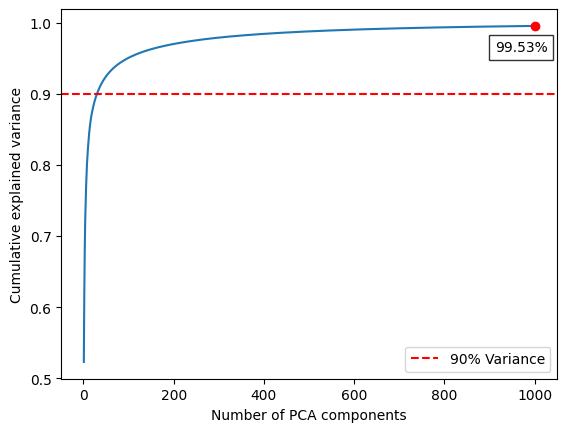

In [ ]:
# 4. Plot the explained variance (optional)
variance_1000 = cumulative_variance[-1] * 100
plt.plot(range(1, 1001), cumulative_variance)
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')

# Mark the point at 1000 components
plt.scatter(1000, cumulative_variance[-1], color='red', zorder=5)
plt.text(970, cumulative_variance[-1] - 0.02,
         f'{variance_1000:.2f}%',
         ha='center', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.show()

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(featuresf2, labelsf ,  random_state=42,   test_size=0.20,   shuffle=True)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=10, random_state=42)
svm_rbf.fit(X_train, y_train)


y_predict = svm_rbf.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9110    0.9301    0.9204       143
           1     0.9759    0.9659    0.9708       293
           2     0.9831    0.9831    0.9831       177

    accuracy                         0.9625       613
   macro avg     0.9566    0.9597    0.9581       613
weighted avg     0.9628    0.9625    0.9626       613



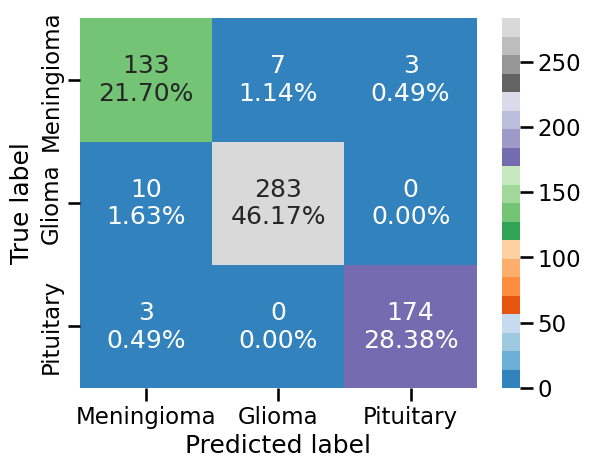

In [ ]:
cf_matrix = confusion_matrix(y_test , y_predict)
labels_n = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels_n , categories=categories, cmap='tab20c')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)
knn.fit(X_train, y_train)


y_predict = knn.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9371    0.9371    0.9371       143
           1     0.9694    0.9727    0.9710       293
           2     1.0000    0.9944    0.9972       177

    accuracy                         0.9706       613
   macro avg     0.9688    0.9680    0.9684       613
weighted avg     0.9707    0.9706    0.9707       613



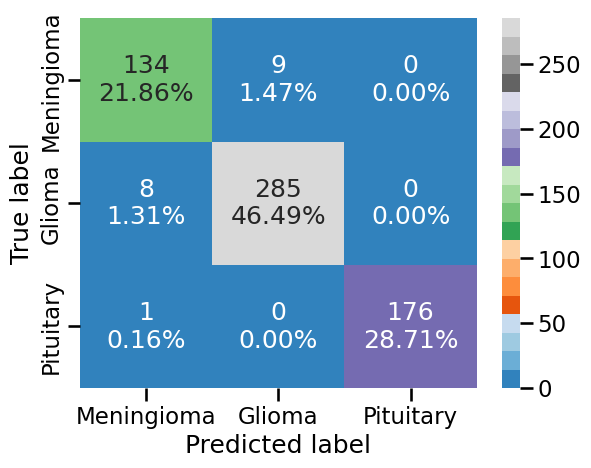

In [ ]:
cf_matrix = confusion_matrix(y_test , y_predict)
labels_n  = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels_n , categories=categories, cmap='tab20c')

In [ ]:
svc = SVC(kernel='rbf',C=10, random_state=42)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [96.25, 96.9, 97.06, 97.55, 95.75]
Mean accuracy: 96.7
Standard deviation: 0.71
95% Confidence Interval: [95.82%, 97.58%]
Final result: 96.7% ± 0.71%
With 95% CI: 96.7% (95.82%-97.58%)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [97.06, 95.27, 96.41, 96.57, 96.24]
Mean accuracy: 96.31
Standard deviation: 0.66
95% Confidence Interval: [95.49%, 97.13%]
Final result: 96.31% ± 0.66%
With 95% CI: 96.31% (95.49%-97.13%)


In [ ]:
# Load pre-trained VGG16 model as a feature extractor (without classification layers)
model = VGG16(include_top=False, input_shape=(224, 224, 3))

# Freeze all layers to preserve pre-trained weights and speed up processing
for layer in model.layers:
    layer.trainable = False

# Convert the final convolutional layer output to 1D feature vector
output = Flatten()(model.layers[-1].output)

# Create the final feature extraction model
model = Model(inputs=model.inputs, outputs=output)

# Display model architecture for verification
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Initialize feature array and labels list for VGG16 features
# VGG16 produces 512x7x7 = 25088 features after flattening
featuresb2 = []
labels = []
n = 25088  # Feature vector size for VGG16

# Counter for handling first sample initialization
i=0

# Extract VGG16 features from glioma images
for image_path in glioma:
    # Get features and reshape to 1D vector
    feature_vector = np.reshape(get_features(image_path), (1, n))

    # Initialize array with first sample or append subsequent ones
    if i == 0:
        featuresb2 = feature_vector
        print(f"VGG16 feature array shape: {featuresb2.shape}")
    else:
        featuresb2 = np.append(featuresb2, feature_vector, axis=0)

    labels.append('glioma')
    i+=1

# Extract VGG16 features from meningioma images
for image_path in meningioma:
    feature_vector = np.reshape(get_features(image_path), (1, n))
    featuresb2 = np.append(featuresb2, feature_vector, axis=0)
    labels.append('meningioma')

# Extract VGG16 features from pituitary images
for image_path in pituitary:
    feature_vector = np.reshape(get_features(image_path), (1, n))
    featuresb2 = np.append(featuresb2, feature_vector, axis=0)
    labels.append('pituitary')

(1, 25088)


In [ ]:
featuresf =  featuresb2
labelsf = labels

In [ ]:
labelsf = [int(0) if x=='meningioma' else x for x in labelsf]
labelsf= [int(1) if x=='glioma' else x for x in labelsf]
labelsf= [int(2) if x=='pituitary' else x for x in labelsf]

In [ ]:
pca = PCA(n_components= 1000, random_state=42)
featuresf2 = pca.fit_transform(featuresf)

In [ ]:
# 3. Check cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by 1000 components: {cumulative_variance[-1] * 100:.2f}%")

Variance explained by 1000 components: 90.13%


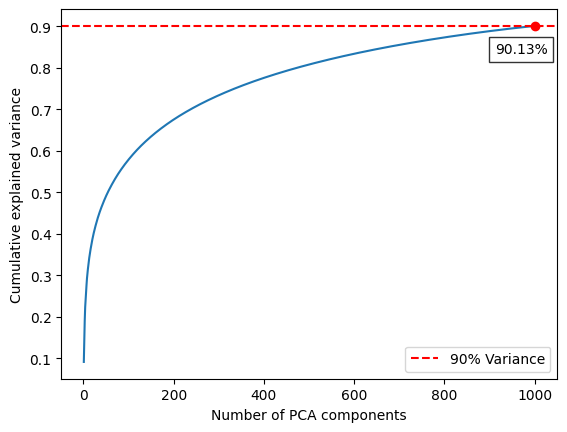

In [ ]:
# 4. Plot the explained variance (optional)
variance_1000 = cumulative_variance[-1] * 100
plt.plot(range(1, 1001), cumulative_variance)
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')

# Mark the point at 1000 components
plt.scatter(1000, cumulative_variance[-1], color='red', zorder=5)
plt.text(970, cumulative_variance[-1] - 0.04,
         f'{variance_1000:.2f}%',
         ha='center', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.show()

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(featuresf2, labelsf ,  random_state=42,   test_size=0.20,   shuffle=True)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=10, random_state=42)
svm_rbf.fit(X_train, y_train)

y_predict = svm_rbf.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9091    0.9091    0.9091       143
           1     0.9626    0.9659    0.9642       293
           2     0.9886    0.9831    0.9858       177

    accuracy                         0.9576       613
   macro avg     0.9534    0.9527    0.9531       613
weighted avg     0.9576    0.9576    0.9576       613



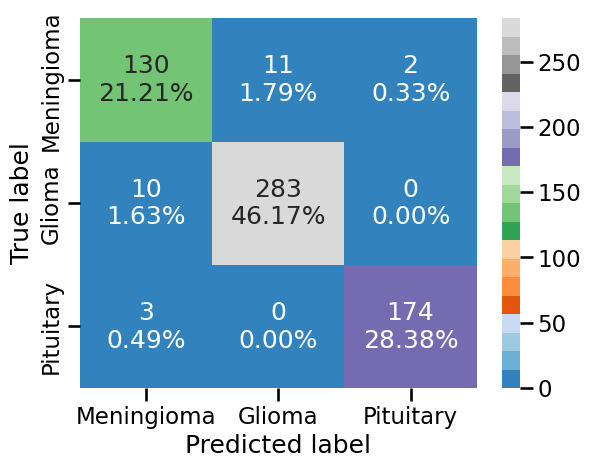

In [ ]:
cf_matrix = confusion_matrix(y_test , y_predict)
labels_n  = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels_n , categories=categories, cmap='tab20c')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)
knn.fit(X_train, y_train)


y_predict = knn.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9275    0.8951    0.9110       143
           1     0.9593    0.9659    0.9626       293
           2     0.9833    1.0000    0.9916       177

    accuracy                         0.9592       613
   macro avg     0.9567    0.9537    0.9551       613
weighted avg     0.9588    0.9592    0.9589       613



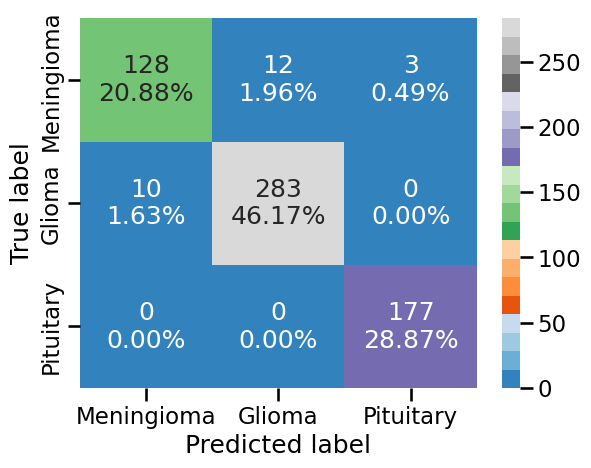

In [ ]:
cf_matrix = confusion_matrix(y_test , y_predict)
labels_n  = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels_n , categories=categories, cmap='tab20c')

In [ ]:
svc = SVC(kernel='rbf',C=10, random_state=42)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [95.76, 95.6, 97.23, 97.23, 96.08]
Mean accuracy: 96.38
Standard deviation: 0.79
95% Confidence Interval: [95.39%, 97.36%]
Final result: 96.38% ± 0.79%
With 95% CI: 96.38% (95.39%-97.36%)


In [ ]:
def cohens_d_paired(group1, group2):
    """Cohen's d for paired samples"""
    # Calculate differences
    differences = np.array(group1) - np.array(group2)

    # Cohen's d for paired data = mean_diff / std_diff
    d = np.mean(differences) / np.std(differences, ddof=1)
    return d

In [ ]:
model_acc = np.array([95.76, 95.6, 97.23, 97.23, 96.08])  # VGG16-SVC
baseline_acc = np.array([96.25, 96.9, 97.06, 97.55, 95.75])  # DenseNet121-SVC
# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")

d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -1.1204, p-value = 0.3253
The performance difference is NOT statistically significant.
Cohen's d (paired): -0.50


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [95.92, 95.27, 96.9, 96.57, 96.08]
Mean accuracy: 96.15
Standard deviation: 0.63
95% Confidence Interval: [95.37%, 96.93%]
Final result: 96.15% ± 0.63%
With 95% CI: 96.15% (95.37%-96.93%)


In [ ]:
model_acc = np.array([95.92, 95.27, 96.9, 96.57, 96.08])  # VGG16-KNN
baseline_acc = np.array([97.06, 95.27, 96.41, 96.57, 96.24])  # DenseNet121-KNN

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -0.6050, p-value = 0.5778
The performance difference is NOT statistically significant.
Cohen's d (paired): -0.27


In [ ]:
# Concatenate features from DenseNet121 and VGG16 models along the feature axis
# This creates fused feature vectors by combining both feature sets for each sample
# DenseNet121 features (50176 dim) + VGG16 features (25088 dim) = Fused features (75264 dim)
features = np.concatenate((featuresb1, featuresb2), axis=1)

In [ ]:
featuresf =  features

In [ ]:
labelsf = [int(0) if x=='meningioma' else x for x in labelsf]
labelsf= [int(1) if x=='glioma' else x for x in labelsf]
labelsf= [int(2) if x=='pituitary' else x for x in labelsf]

In [ ]:
pca = PCA(n_components= 1000, random_state=42)
featuresf2 = pca.fit_transform(featuresf)

In [ ]:
# 3. Check cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by 1000 components: {cumulative_variance[-1] * 100:.2f}%")

Variance explained by 1000 components: 94.18%


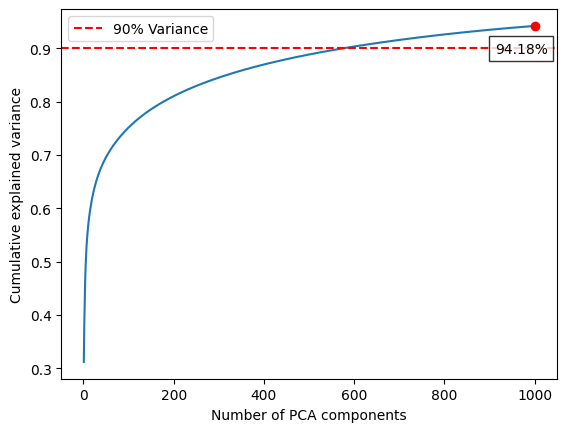

In [ ]:
variance_1000 = cumulative_variance[-1] * 100
plt.plot(range(1, 1001), cumulative_variance)
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')

# Mark the point at 1000 components
plt.scatter(1000, cumulative_variance[-1], color='red', zorder=5)
plt.text(970, cumulative_variance[-1] - 0.03,
         f'{variance_1000:.2f}%',
         ha='center', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.show()

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(featuresf2, labelsf ,  random_state=42,   test_size=0.20,   shuffle=True)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=10, random_state=42)
svm_rbf.fit(X_train, y_train)


y_predict = svm_rbf.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9320    0.9580    0.9448       143
           1     0.9862    0.9761    0.9811       293
           2     0.9886    0.9831    0.9858       177

    accuracy                         0.9739       613
   macro avg     0.9689    0.9724    0.9706       613
weighted avg     0.9743    0.9739    0.9740       613



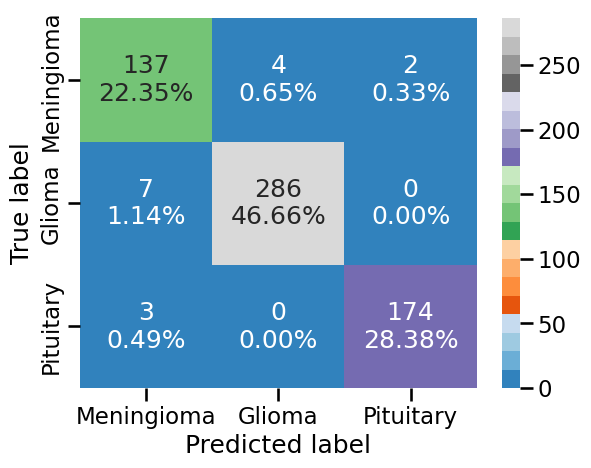

In [ ]:
cf_matrix = confusion_matrix(y_test, y_predict)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)
knn.fit(X_train, y_train)


y_predict = knn.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9583    0.9650    0.9617       143
           1     0.9829    0.9795    0.9812       293
           2     1.0000    1.0000    1.0000       177

    accuracy                         0.9821       613
   macro avg     0.9804    0.9815    0.9810       613
weighted avg     0.9821    0.9821    0.9821       613



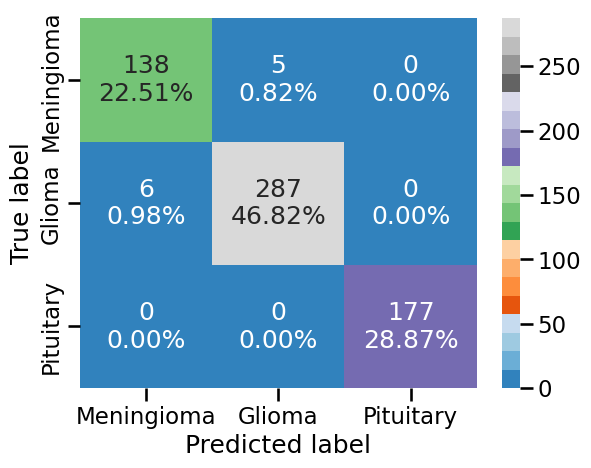

In [ ]:
cf_matrix = confusion_matrix(y_test, y_predict)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

In [ ]:
svc = SVC(kernel='rbf',C=10, random_state=42)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [97.39, 96.9, 98.04, 98.21, 96.9]
Mean accuracy: 97.49
Standard deviation: 0.62
95% Confidence Interval: [96.72%, 98.25%]
Final result: 97.49% ± 0.62%
With 95% CI: 97.49% (96.72%-98.25%)


In [ ]:
model_acc = np.array([95.76, 95.6, 97.23, 97.23, 96.08])  # VGG16-SVC
baseline_acc = np.array([97.39, 96.9, 98.04, 98.21, 96.9])  # Fusion-SVC

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -7.0253, p-value = 0.0022
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -3.14


In [ ]:
model_acc = np.array([96.25, 96.9, 97.06, 97.55, 95.75])  # DenseNet121-SVC
baseline_acc = np.array([97.39, 96.9, 98.04, 98.21, 96.9])  # Fusion-SVC

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -3.6467, p-value = 0.0218
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -1.63


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [98.21, 97.06, 97.39, 98.37, 97.39]
Mean accuracy: 97.68
Standard deviation: 0.57
95% Confidence Interval: [96.97%, 98.39%]
Final result: 97.68% ± 0.57%
With 95% CI: 97.68% (96.97%-98.39%)


In [ ]:
model_acc = np.array([95.92, 95.27, 96.9, 96.57, 96.08])  # VGG16-KNN
baseline_acc = np.array([98.21, 97.06, 97.39, 98.37, 97.39])  # Fusion-KNN

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -5.0532, p-value = 0.0072
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -2.26


In [ ]:
model_acc = np.array([97.06, 95.27, 96.41, 96.57, 96.24])  # DenseNet121-KNN
baseline_acc = np.array([98.21, 97.06, 97.39, 98.37, 97.39])  # Fusion-KNN

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -7.8667, p-value = 0.0014
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -3.52


In [ ]:
# Apply Borderline-SMOTE (Synthetic Minority Over-sampling Technique) to handle class imbalance
# Borderline-SMOTE is an advanced oversampling method that focuses on minority samples near the class boundary
# This helps create more meaningful synthetic samples compared to basic SMOTE

# Initialize Borderline-SMOTE with specific parameters:
# - sampling_strategy='not majority': Resample all classes except the majority class
# - kind='borderline-1': Focus on minority samples that are misclassified by k-NN (more conservative approach)
# - k_neighbors=5: Number of nearest neighbors used to generate synthetic samples (default)
# - m_neighbors=10: Number of nearest neighbors used to determine if a minority sample is in "danger" (default)
# - random_state=42: Ensures reproducible results across runs
oversample = BorderlineSMOTE(sampling_strategy='not majority',
                            kind='borderline-1',
                            k_neighbors=5,
                            m_neighbors=10,
                            random_state=42)

# Apply the oversampling to balance the dataset
# This generates synthetic samples for minority classes to create a balanced distribution
featuresf, labelsf = oversample.fit_resample(featuresf, labelsf)

# After resampling:
# - featuresf: Contains original samples + newly generated synthetic samples
# - labelsf: Contains corresponding labels for all samples (balanced distribution)
# - The dataset now has equal representation across all classes, improving model performance on minority classes

In [ ]:

# Create a NumPy array
arr = np.array(labelsf)

# Get unique elements and their counts
unique_elements, counts = np.unique(arr, return_counts=True)

# Display the results
for element, count in zip(unique_elements, counts):
    print(f"Element {element} occurs {count} times.")

Element 0 occurs 1426 times.
Element 1 occurs 1426 times.
Element 2 occurs 1426 times.


In [ ]:
pca = PCA(n_components= 1000, random_state=42)
featuresf2 = pca.fit_transform(featuresf)

In [ ]:
# 3. Check cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
print(f"Variance explained by 1000 components: {cumulative_variance[-1] * 100:.2f}%")

Variance explained by 1000 components: 95.47%


In [ ]:
cumulative_variance[-1]

np.float64(0.954710551272894)

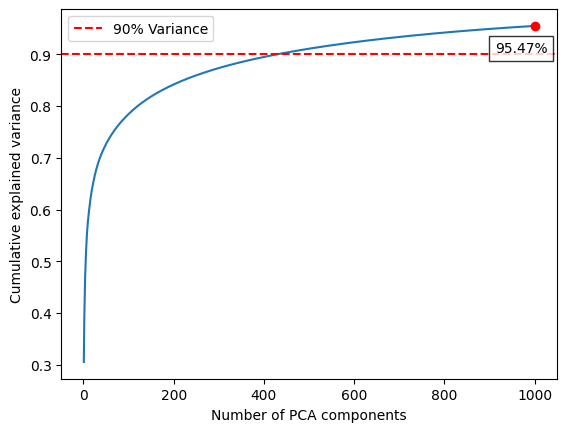

In [ ]:
variance_1000 = cumulative_variance[-1] * 100
plt.plot(range(1, 1001), cumulative_variance)
plt.xlabel('Number of PCA components')
plt.ylabel('Cumulative explained variance')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% Variance')

# Mark the point at 1000 components
plt.scatter(1000, cumulative_variance[-1], color='red', zorder=5)
plt.text(970, cumulative_variance[-1] - 0.03,
         f'{variance_1000:.2f}%',
         ha='center', va='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.legend()
plt.show()

In [ ]:
X_train, X_test,  y_train, y_test = train_test_split(featuresf2, labelsf ,  random_state=42,   test_size=0.20,   shuffle=True)

In [ ]:
svm_rbf = SVC(kernel='rbf', C=10, random_state=42)
svm_rbf.fit(X_train, y_train)


y_predict = svm_rbf.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9839    1.0000    0.9919       244
           1     1.0000    0.9905    0.9952       317
           2     1.0000    0.9966    0.9983       295

    accuracy                         0.9953       856
   macro avg     0.9946    0.9957    0.9951       856
weighted avg     0.9954    0.9953    0.9953       856



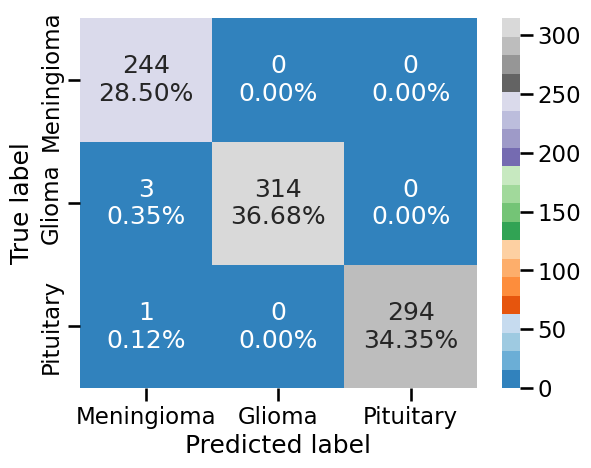

In [ ]:
cf_matrix = confusion_matrix(y_test, y_predict)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p=2)
knn.fit(X_train, y_train)


y_predict = knn.predict(X_test)
print(classification_report(y_test, y_predict,digits=4))

              precision    recall  f1-score   support

           0     0.9717    0.9836    0.9776       244
           1     0.9873    0.9779    0.9826       317
           2     1.0000    1.0000    1.0000       295

    accuracy                         0.9871       856
   macro avg     0.9863    0.9872    0.9867       856
weighted avg     0.9872    0.9871    0.9872       856



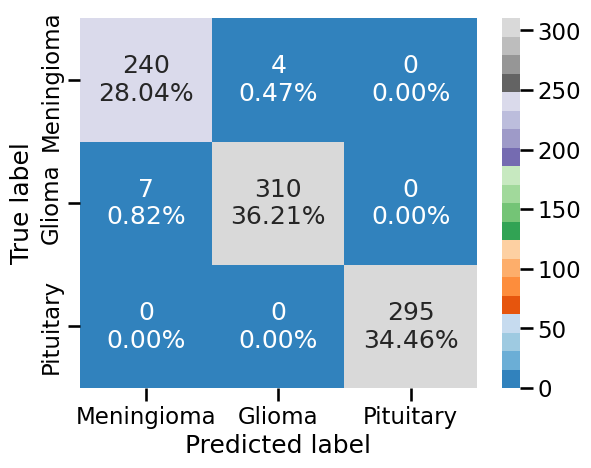

In [ ]:
cf_matrix = confusion_matrix(y_test, y_predict)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Meningioma', 'Glioma',  'Pituitary']
make_confusion_matrix(cf_matrix, group_names=labels, categories=categories, cmap='tab20c')

In [ ]:
svc = SVC(kernel='rbf',C=10, random_state=42)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [99.53, 97.78, 98.83, 99.06, 98.95]
Mean accuracy: 98.83
Standard deviation: 0.65
95% Confidence Interval: [98.03%, 99.63%]
Final result: 98.83% ± 0.65%
With 95% CI: 98.83% (98.03%-99.63%)


In [ ]:
model_acc = np.array([95.76, 95.6, 97.23, 97.23, 96.08])  # VGG16-SVC
baseline_acc = np.array([99.53, 97.78, 98.83, 99.06, 98.95])  # Fusion-Augmented-SVC

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -6.2244, p-value = 0.0034
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -2.78


In [ ]:
model_acc = np.array([96.25, 96.9, 97.06, 97.55, 95.75])  # DenseNet121-SVC
baseline_acc = np.array([99.53, 97.78, 98.83, 99.06, 98.95])  # Fusion-Augmented-SVC

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -4.4645, p-value = 0.0111
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -2.00


In [ ]:
model_acc = np.array([97.39, 96.9, 98.04, 98.21, 96.9])  # Fusion-SVC
baseline_acc = np.array([99.53, 97.78, 98.83, 99.06, 98.95])  # Fusion-Augmented-SVC

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -4.3560, p-value = 0.0121
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -1.95


In [ ]:
knn = KNeighborsClassifier(n_neighbors=1, p = 2)  # Adjust hyperparameters as needed

kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for train_index, test_index in kf.split(featuresf2):
    X_train, X_test = featuresf2[train_index], featuresf2[test_index]
    y_train, y_test = np.array(labelsf)[train_index], np.array(labelsf)[test_index]

    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc*100)

# Calculate statistics
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies, ddof=1)  # sample standard deviation
n = len(accuracies)

# Calculate 95% Confidence Interval
ci = stats.t.interval(0.95, df=n-1, loc=mean_acc, scale=std_acc/np.sqrt(n))

print("Fold accuracies:", [round(num, 2) for num in accuracies])
print("Mean accuracy:", round(mean_acc, 2))
print("Standard deviation:", round(std_acc, 2))
print("95% Confidence Interval:", f"[{ci[0]:.2f}%, {ci[1]:.2f}%]")
print("Final result:", f"{round(mean_acc, 2)}% ± {round(std_acc, 2)}%")
print("With 95% CI:", f"{round(mean_acc, 2)}% ({ci[0]:.2f}%-{ci[1]:.2f}%)")

Fold accuracies: [98.71, 98.01, 98.48, 99.06, 98.71]
Mean accuracy: 98.6
Standard deviation: 0.39
95% Confidence Interval: [98.12%, 99.08%]
Final result: 98.6% ± 0.39%
With 95% CI: 98.6% (98.12%-99.08%)


In [ ]:
model_acc = np.array([95.92, 95.27, 96.9, 96.57, 96.08])  # VGG16-KNN
baseline_acc = np.array([98.71, 98.01, 98.48, 99.06, 98.71])  # Fusion-Augmented-KNN

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -10.9911, p-value = 0.0004
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -4.92


In [ ]:
model_acc = np.array([97.06, 95.27, 96.41, 96.57, 96.24])  # DenseNet121-KNN
baseline_acc = np.array([98.71, 98.01, 98.48, 99.06, 98.71])  # Fusion-Augmented-KNN

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -11.9328, p-value = 0.0003
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -5.34


In [ ]:
model_acc = np.array([98.21, 97.06, 97.39, 98.37, 97.39])  # Fusion-KNN
baseline_acc = np.array([98.71, 98.01, 98.48, 99.06, 98.71])  # Fusion-Augmented-KNN

# Perform a paired t-test
t_stat, p_value = ttest_rel(model_acc, baseline_acc)

print(f"Paired t-test results:")
print(f"t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

if p_value < 0.05:
    print("The performance difference is statistically significant (p < 0.05).")
else:
    print("The performance difference is NOT statistically significant.")
d_paired = cohens_d_paired(model_acc, baseline_acc)
print(f"Cohen's d (paired): {d_paired:.2f}")

Paired t-test results:
t-statistic = -6.2901, p-value = 0.0033
The performance difference is statistically significant (p < 0.05).
Cohen's d (paired): -2.81


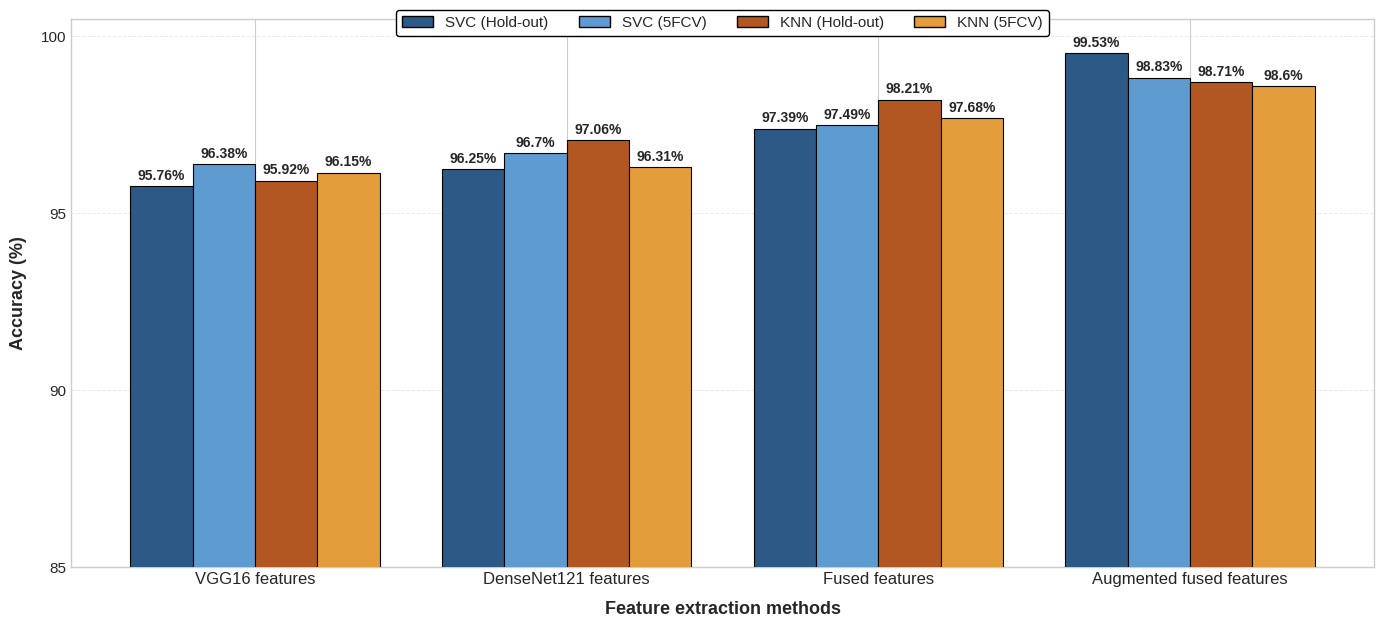

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import matplotlib as mpl
from matplotlib.patches import Patch

# === PROFESSIONAL ACADEMIC STYLING ===
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman', 'DejaVu Serif', 'Georgia']
rcParams['font.size'] = 12
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 13
rcParams['xtick.labelsize'] = 11
rcParams['ytick.labelsize'] = 11
rcParams['axes.linewidth'] = 1.0
rcParams['axes.edgecolor'] = 'black'
rcParams['axes.titlepad'] = 15

# Data - REPLACE WITH YOUR VALUES
data = {
    'VGG16 features': {
        'SVC Hold-out': 95.76,
        'SVC 5FCV': 96.38,
        'KNN Hold-out': 95.92,
        'KNN 5FCV': 96.15
    },
    'DenseNet121 features': {
        'SVC Hold-out': 96.25,
        'SVC 5FCV': 96.7,
        'KNN Hold-out': 97.06,
        'KNN 5FCV': 96.31
    },
    'Fused features': {
        'SVC Hold-out': 97.39,
        'SVC 5FCV': 97.49,
        'KNN Hold-out': 98.21,
        'KNN 5FCV': 97.68
    },
    'Augmented fused features': {
        'SVC Hold-out': 99.53,
        'SVC 5FCV': 98.83,
        'KNN Hold-out': 98.71,
        'KNN 5FCV': 98.60
    }
}

# Setup
groups = list(data.keys())
metrics = ['SVC Hold-out', 'SVC 5FCV', 'KNN Hold-out', 'KNN 5FCV']

# REFINED ACADEMIC COLOR PALETTE
colors = [
    '#2d5986',  # Prussian blue (SVC Hold-out)
    '#5d9bd1',  # Cerulean (SVC 5FCV)
    '#b35722',  # Terracotta (KNN Hold-out)
    '#e39d3a'   # Ochre (KNN 5FCV)
]

x = np.arange(len(groups))  # Group locations
width = 0.2  # Width of individual bars

# Create figure with academic styling
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(14, 7), dpi=100)
fig.set_facecolor('white')

# Plot each metric with academic styling
for i, metric in enumerate(metrics):
    values = [data[group][metric] for group in groups]
    bars = ax.bar(x + i*width, values, width,
                 color=colors[i],
                 edgecolor='black',
                 linewidth=0.8,
                 zorder=3)

    # Add data labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.1,
                f'{height}%', ha='center', va='bottom', fontsize=10,
                fontweight='bold')

# === AXIS AND TITLE STYLING ===
ax.set_ylabel('Accuracy (%)', fontweight='bold', labelpad=10)
ax.set_xlabel('Feature extraction methods', fontweight='bold', labelpad=10)


# X-axis configuration
ax.set_xticks(x + width*1.5)
ax.set_xticklabels(groups, fontsize=12)
ax.set_ylim(85, 100.5)  # Start from 50 as requested
ax.set_yticks(np.arange(85, 101, 5))  # Academic tick spacing

# Add horizontal line at 50 for reference
#ax.axhline(y=50, color='gray', linestyle='-', alpha=0.4, linewidth=0.8)

# === GRID ENHANCEMENTS ===
ax.grid(axis='y', linestyle='--', alpha=0.4, linewidth=0.7)


# === PROFESSIONAL LEGEND ===
legend_elements = [
    Patch(facecolor=colors[0], edgecolor='black', label='SVC (Hold-out)'),
    Patch(facecolor=colors[1], edgecolor='black', label='SVC (5FCV)'),
    Patch(facecolor=colors[2], edgecolor='black', label='KNN (Hold-out)'),
    Patch(facecolor=colors[3], edgecolor='black', label='KNN (5FCV)')
]

# Place legend inside the grid area at top center
legend = ax.legend(handles=legend_elements, loc='upper center',
                  ncol=4, frameon=True, fontsize=11,
                  bbox_to_anchor=(0.5, 1.03),  # Position above plot area
                  framealpha=1.0,  # Solid background
                  edgecolor='black',
                  facecolor='white')

# === FINAL REFINEMENTS ===


# Add caption space

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Space for caption

# Save as publication-quality figure
plt.savefig('academic_comparison.png', dpi=300, bbox_inches='tight')
plt.show()